In [401]:
# from google.colab import drive # remove the cell if not using colab
# drive.mount('/content/drive')

In [402]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('./') # change path here!

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

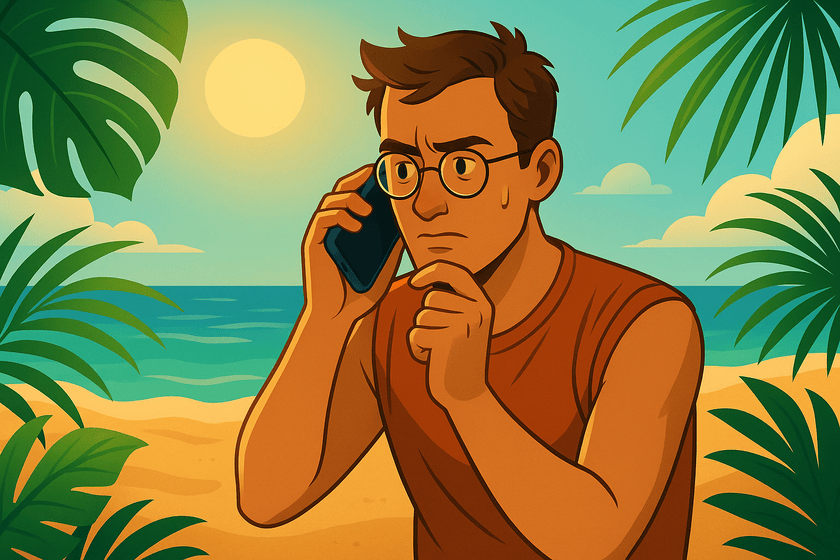

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [403]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [404]:
titanic_df['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [405]:
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Właściwa część zadania

## Podsumowanie pierwszego pliku

### Zmiany w zbiorze danych

W poprzednim zadaniu okazało się przede wszystkim, że nie wszystkie zmienne zbioru danych _titanic_ są potrzebne w celu dalszej analizy. Zbędnymi okazały się kolumny: _Name_, _Ticket_ i _Embarked_, więc zostaną one wykluczone ze zbioru.

Kolejną sprawą była stworzenie z kolumny _Cabin_ pochodnej zmiennej *Cabin_type* poprzez ustalenie pierwszej literki z wartości danego wiersza jako nowej wartości *Cabin_type* (np. dla "C123 D231" wartością w nowej kolumnie byłoby C). Następnie oryginalna kolumna została usunięta, a nowej zostało zmienione kodowanie. Komórkę z brakiem wartości traktuję jako 0, a każdą literkę alfabetycznie jako kolejne cyfry od 1 do 8. Liczby przy numerze kabiny okazały się zbędne. Zmianę kodowania zastosowałam także dla zmiennej _Sex_ - 0 oznacza poprzednią wartość _male_, a 1 _female_.

Ostatnią ważną korektą było uzupełnienie braków danych w kolumnach _Age_ i _Fare_. W obydwu przypadkach najbardziej optymalną metodą okazało się przypisanie brakującym wartościom losowe wartości z rozkładu całych kolumn.

In [406]:
titanic_df = titanic_df.drop(columns = ['Name', 'Ticket', 'Embarked'])
titanic_df = titanic_df.convert_dtypes()
titanic_df['Sex'] = titanic_df.Sex.map({
    'female': 1, 'male': 0
})
titanic_df['Cabin'] = titanic_df['Cabin'].str[0]
titanic_df['Cabin'] = titanic_df['Cabin'].fillna('0')
titanic_df['Cabin'] = titanic_df.Cabin.map({
    '0': 0, 'T': 8, 'G': 7, 'F': 6, 'E': 5, 'D': 4, 'C': 3, 'B': 2, 'A': 1
})

def get_rid_of_na_by_column_distribution(df, column):
    count_prob = df[column].value_counts(normalize=True)
    values = count_prob.index
    probs = count_prob.values
    missing_vals = df[column].isna()
    df.loc[missing_vals, column] = np.random.choice(values, size=missing_vals.sum(), p=probs)
    return df

titanic_df = get_rid_of_na_by_column_distribution(titanic_df, 'Age')
titanic_df = get_rid_of_na_by_column_distribution(titanic_df, 'Fare')
#display(titanic_df.head())

### Ważne obserwacje

Z poprzedniego pliku wyciągnęłam następujące wnioski:

* istnieje wiele obserwacji odstających w zmiennych _Parch_, _SibSp_ i _Cabin_type_,
* największa korelacja między zmienną Survived występuje dla zmiennych *Pclass*, *Cabin_type* i *Sex*,
* kolumny _Fare_ i *Cabin_type* wykazują się dużą korelacją ze zmienną Pclass,
* zmienne _SibSp_, _Parch_ i _Age_ mają niewielką korelację ze zmienną Survived,
* _SibSp_ i _Parch_ są ze sobą silnie skorelowane,
* w przypadku problemu zbyt dużej liczby wymiarów zmienne _SibSp_, _Parch_, _Fare_ i *Cabin_type* powinny zostać usunięte, gdyż wnoszą najmniejszą liczbę informacji.

## Trening modeli

In [407]:
# ustawienia początkowe 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

seed = 2137
np.random.seed(seed)

X = titanic_df.drop("Survived", axis=1)
X[['Age', 'Fare']] = StandardScaler().fit_transform(X[['Age', 'Fare']])
y = titanic_df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True, random_state=seed)

In [408]:
#definicja ocen klasyfikacji
def clasif_error(test, pred):
    mx = confusion_matrix(test, pred)
    diag = np.diag(mx).sum()
    return 1 -((diag * 1.0) / (test.size))
def sensiv(test, pred):
    mx = confusion_matrix(test, pred)
    if (mx[1][1] == 0):
        return 0.0
    return (mx[1][1]) / (mx[1][0] + mx[1][1])
def specf(test, pred):
    mx = confusion_matrix(test, pred)
    if (mx[0][0] == 0):
        return 0.0
    return (mx[0][0]) / (mx[0][0] + mx[0][1])

def full_stats(test, pred):
    clas = str(round(clasif_error(test, pred) * 100, 2)) + '%'
    sens = str(round(sensiv(test, pred) * 100, 2)) + '%'
    spec = str(round(specf(test, pred) * 100, 2)) + '%'
    print(f'Błąd klasyfikacji: {clas}\nCzułość: {sens}\nSpecyficzność: {spec}')

def coolplt(test, pred, val, par, dis = 1):
    er = [clasif_error(test, p) for p in pred]
    se = [sensiv(test, p) for p in pred]
    sp = [specf(test, p) for p in pred]
    if (dis == 1):
        x_labels = [str(v) for v in val]
        x_pos = np.arange(len(val))
        plt.plot(x_pos, er, 'o-', color="limegreen", label="Błąd klasyfikacji")
        plt.plot(x_pos, se, 'o-', color="lightblue", label="Czułość")
        plt.plot(x_pos, sp, 'o-', color="deeppink", label="Specyficzność")
        plt.xticks(x_pos, x_labels, rotation=45)
    else:
        plt.plot(val, er, 'o-', color="limegreen", label="Błąd klasyfikacji")
        plt.plot(val, se, 'o-', color="lightblue", label="Czułość")
        plt.plot(val, sp, 'o-', color="deeppink", label="Specyficzność")
    plt.title(f"Wartości poszczególnych kryterium dokładności w zależności od parametru {par}")
    plt.legend()
    plt.xlabel(f"Parametr {par}")
    plt.ylabel(f"Wartości poszczególnych statystyk")

W następnych rozdziałach będę porównywać ze sobą rezultaty treningów poszczególnych modeli w zależności od wartości parametrów. Aby tego dokonać będę posługiwać się następującymi ocenami wyrażonymi w skali od 0 do 1(lub w skali procentowej):

* błąd klasyfikacji: liczba źle zaklasyfikowanych osób w stosunku do łącznej liczby danych - im mniejsza, tym lepszy model.
* czułość: liczba osób, które rzeczywiście przeżyły, w stosunku do łącznej liczby osób zaklasyfikowanych jako ocalali - im większa, tym lepszy model.
* specyficzność: liczba osób, które rzeczywiście umarły, w stosunku do łącznej liczby osób zaklasyfikowanych jako zmarłych - im większa, tym lepszy model.

W celu znalezienia najlepszego modelu zamierzam szukać kompromisu pomiędzy niską wartością błędu, a wysoką czułością i specyficznością.

Aby otrzymywać wyniki, które można porównać, będę działać na z góry określonym zbiorze testowym i uczącym. Ponadto ustawię stałe ziarno dla każdych losowych funkcji, aby ogranicznyć nieprzewidywalność wyników.

W celu uniknięcia dominacji obliczeń przez często występujące wartości odstające kolumny reprezentujące dane ilościowe ciągłe zostały ustandaryzowane.

### Dummy Classifier

In [409]:
model = DummyClassifier(strategy = 'uniform', random_state=seed)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
full_stats(y_test, y_pred)

Błąd klasyfikacji: 49.16%
Czułość: 45.83%
Specyficzność: 54.21%


W przypadku losowej klasyfikacji wszystkie wartości oscylują wokół 50%. Wynik nie jest zaskoczeniem, zdecydowanie tego klasyfikatora nie można uznać za dobry.

### Metoda wektorów nośnych (SVM)

In [410]:
cc = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
gam = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

c_sol = []
for i in cc:
    svm_r = SVC(kernel = 'rbf', C = i, gamma = 0.01, random_state=seed)
    svm_r.fit(X_train, y_train)
    c_sol.append(svm_r.predict(X_test))
c_sol2 = []
for j in gam:
    svm_r2 = SVC(kernel = 'rbf', C = 1000, gamma = j, random_state=seed)
    svm_r2.fit(X_train, y_train)
    c_sol2.append(svm_r2.predict(X_test))

g_sol = []
for i in cc:
    svm_s = SVC(kernel = 'sigmoid', C = i, gamma = 0.01, random_state=seed)
    svm_s.fit(X_train, y_train)
    g_sol.append(svm_s.predict(X_test))
g_sol2 = []
for j in gam:
    svm_s2 = SVC(kernel = 'sigmoid', C = 10, gamma = j, random_state=seed)
    svm_s2.fit(X_train, y_train)
    g_sol2.append(svm_s2.predict(X_test))

Dla modelu SVM zdecydowałam się na wybór dwóch jąder - radialnego i sigmoidalnego ze względu na ich największą plastyczność, a także porównywalne parametry. Zamierzam porównywać wyniki dla wartości gammy oraz C. Wartości aktualnie nieanalizowanych parametrów dopasuję do wartości najlepszych uzyskanych w analizie dla tych parametrów.

#### Jądro radialne

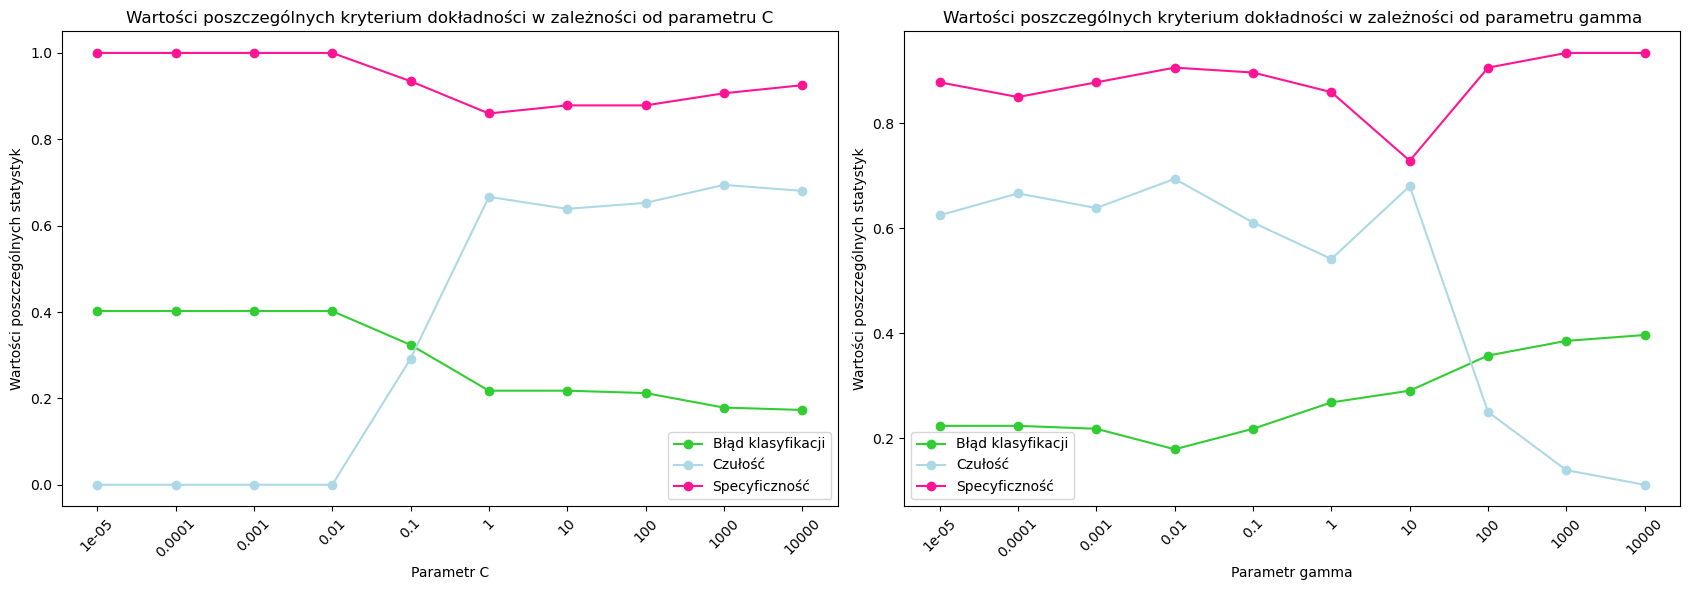

In [411]:
plt.figure(figsize = (17, 6))
plt.subplot(1, 2, 1)
coolplt(y_test, c_sol, cc, 'C')
plt.subplot(1, 2, 2)
coolplt(y_test, c_sol2, gam, 'gamma')
plt.tight_layout()
plt.show()

Dla parametru C algorytm najlepsze wyniki osiąga dla wartości 1000. Dla zbyt niskich wartości model przeucza się i wszystkie osoby klasyfikowane są błędnie jako zmarłe, o czym świadczy 0% czułości i 100% specyficzności. Dla wyższych wartości parametru C model nie ulega zjawisku overfittingu, a wartości poszczególnych parametrów oceny klasyfikacji oscylują na podobnym poziomie, jednak moim zdaniem najlepsze wyniki osiągane są dla C równego 1000.

Co do parametru gamma najlepszą wartością okazało się 0.01. Mimo takiej samej wartości czułości co 10 okazało się mieć większą specyficzność. Co ciekawe, nie licząc skrajnie wysokich wartości, model nie ma tendencji do przeuczenia.

#### Jądro sigmoidalne

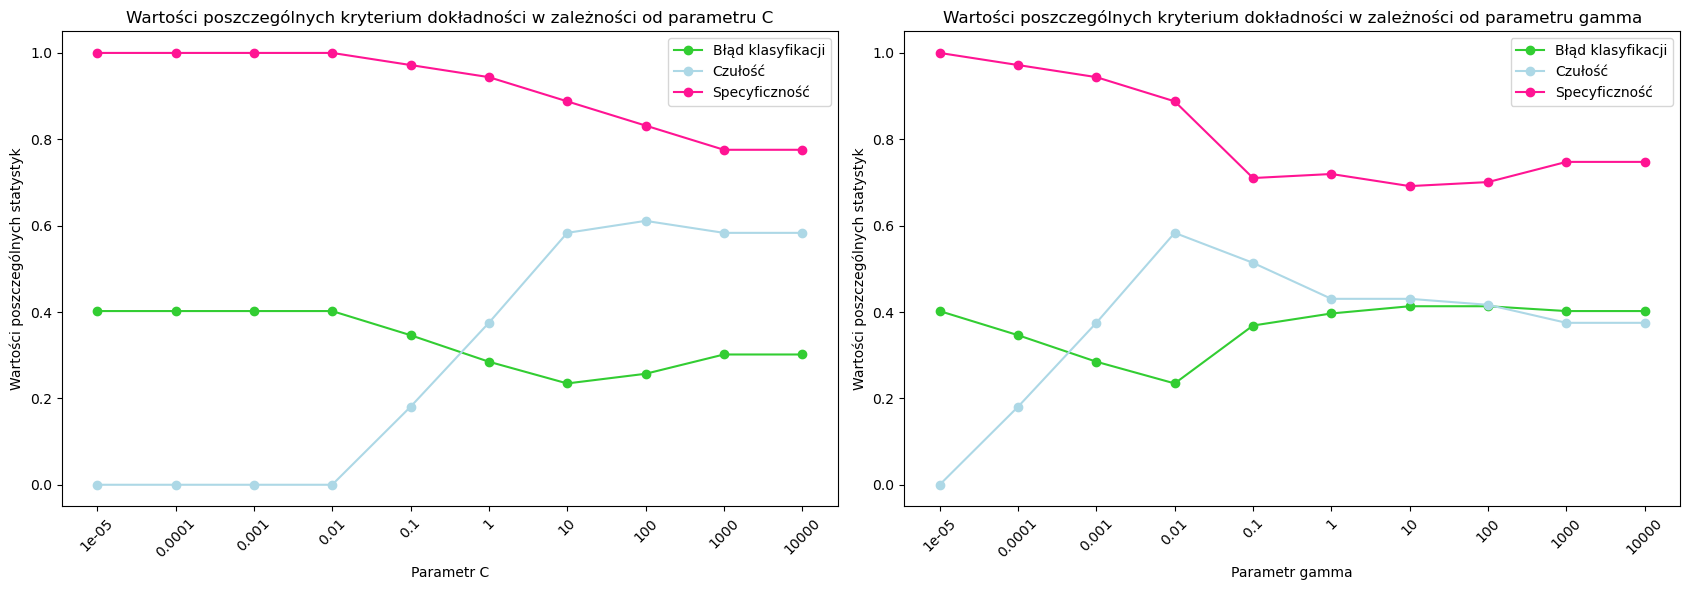

In [412]:
plt.figure(figsize = (17, 6))
plt.subplot(1, 2, 1)
coolplt(y_test, g_sol, cc, 'C')
plt.subplot(1, 2, 2)
coolplt(y_test, g_sol2, gam, 'gamma')
plt.tight_layout()
plt.show()

Tym razem dla parametru C ciężko określić jednoznaczą najlepszą wartość. Na pewno dla skrajnie niskich wartości model ulega przeuczeniu. Jednakże najwyższą wartość czułości osiąga dla 100, zaś najniższy błąd klasyfikacji dla 10. Moim zdaniem, ze względu na większy spadek specyficzności niż wzrost czułości, najlepsze wyniki model osiąga dla C równego 10.

Co do parametru gamma najlepszą wartością okazało się 0.01. Ponownie, dla tego parametru model nie ma aż tak dużych tendencji do przeuczania, co dla parametru C.

### Algorytm k-najbliższych sąsiadów (KNN)

In [413]:
pr = []
for i in ['rogerstanimoto', 'cityblock', 'correlation', 'p', 'sokalmichener', 'dice', 'chebyshev', 'l2', 'manhattan', 'sqeuclidean', 'canberra', 'minkowski', 'cosine', 'infinity', 'jaccard', 'russellrao', 'sokalsneath', 'euclidean', 'nan_euclidean', 'braycurtis', 'hamming', 'l1']:
    knn = KNeighborsClassifier(n_neighbors = 5, metric = i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    pr.append([clasif_error(y_test, y_pred), i])
pr.sort()
besto = pr[1][1]
#besto

In [ ]:
neigh = np.linspace(1, 100, 20, dtype=int)
weigh = ['uniform', 'distance']

n_sol = []
for i in neigh:
    knn_cos = KNeighborsClassifier(n_neighbors = i, metric = 'cosine', weights = 'distance')
    knn_cos.fit(X_train, y_train)
    n_sol.append(knn_cos.predict(X_test))
w_sol = []
for j in weigh:
    knn_cos2 = KNeighborsClassifier(n_neighbors = 16, metric = 'cosine', weights = j)
    knn_cos2.fit(X_train, y_train)
    w_sol.append(knn_cos2.predict(X_test))

n_sol2 = []
for i in neigh:
    knn_can = KNeighborsClassifier(n_neighbors = i, metric = besto, weights = 'distance')
    knn_can.fit(X_train, y_train)
    n_sol2.append(knn_can.predict(X_test))
w_sol2 = []
for j in weigh:
    knn_can2 = KNeighborsClassifier(n_neighbors = 26, metric = besto, weights = j)
    knn_can2.fit(X_train, y_train)
    w_sol2.append(knn_can2.predict(X_test))

Dla modelu KNN zdecydowałam się na wybór metryki pasującej do zbioru danych opartego w głównej mierze na danych jakościowych - metryki cosine, a także tej, która wytworzy najmniejszy błąd klasyfikacji spośród wszystkich obsługiwanych przez Pythona metryk. Okazała się nią metryka canberra. Zamierzam porównywać ze sobą wyniki w zależności od wartości parametrów n_neighbors i weights.

#### Metryka cosine

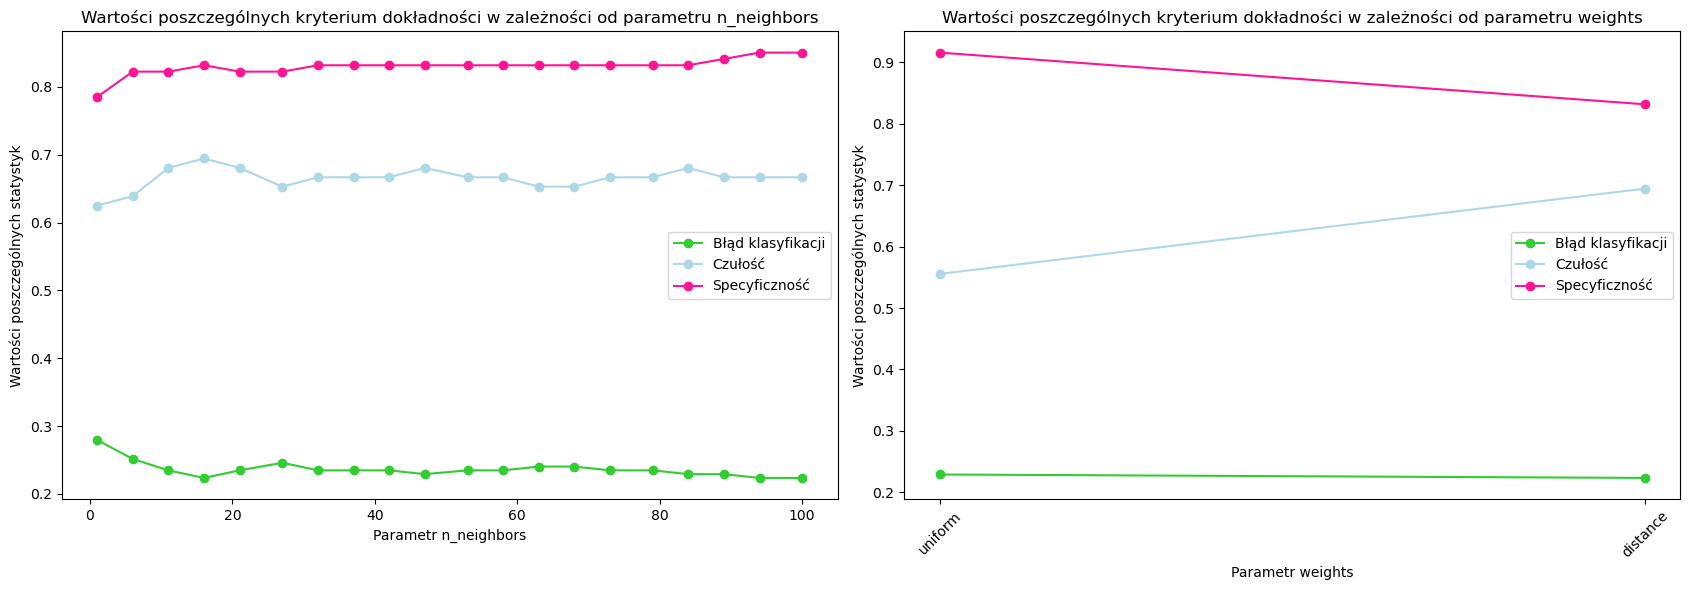

In [415]:
plt.figure(figsize = (17, 6))
plt.subplot(1, 2, 1)
coolplt(y_test, n_sol, neigh, 'n_neighbors', 0)
plt.subplot(1, 2, 2)
coolplt(y_test, w_sol, weigh, 'weights')
plt.tight_layout()
plt.show()

Tym razem model nie musi aż tak mocno opierać się na wartościach poszczególnych parametrów. W obydwu przypadkach wyniki każdego z parametrów oceny klasyfikacji są na podobnym poziomie dla każdej wartości, zarówno n_neighbors jak i weights. Moim zdaniem jednak najlepiej wypadają te parametry równe 16 i distance.

#### Metryka canberra

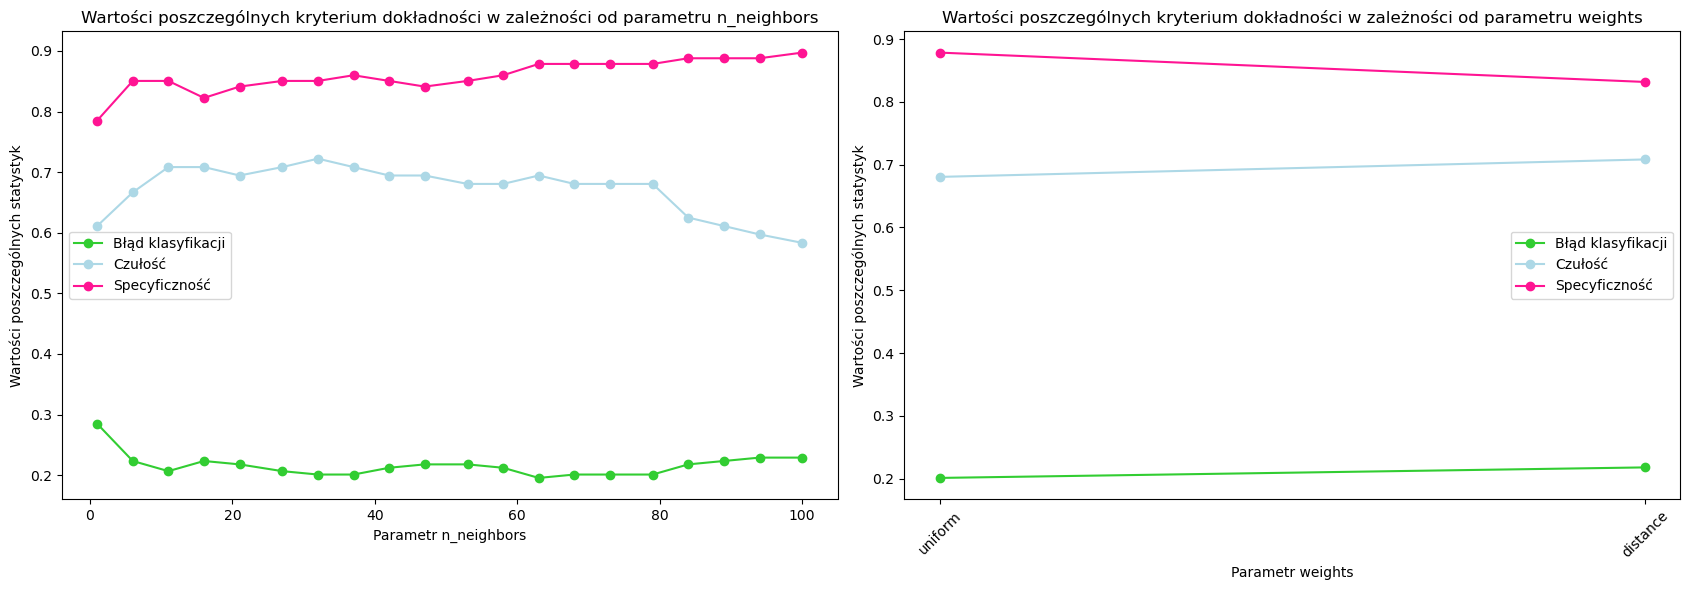

In [416]:
plt.figure(figsize = (17, 6))
plt.subplot(1, 2, 1)
coolplt(y_test, n_sol2, neigh, 'n_neighbors', 0)
plt.subplot(1, 2, 2)
coolplt(y_test, w_sol2, weigh, 'weights')
plt.tight_layout()
plt.show()

Tym razem model jest trochę bardziej zróżnicowany. Dla skrajnych wartości parametru n_neighbors dokładność modelu ulega pogorszeniu, jednak nie jest to drastyczne zjawisko. Moim zdaniem najlepszymi wartościami tym razem są 26 i, ponownie, distance.

## Podsumowanie

Na sam koniec wybiorę najlepszy model spośród wszystkich wybranych wcześniej najlepszych parametrów.

In [400]:
pred = []

model = SVC(kernel = 'rbf', C = 1000, gamma = 0.01, random_state=seed)
model.fit(X_train, y_train)
pred.append([model.predict(X_test), "SVM z jądrem radialnym"])

model = SVC(kernel = 'sigmoid', C = 10, gamma = 0.01, random_state=seed)
model.fit(X_train, y_train)
pred.append([model.predict(X_test), "SVM z jądrem sigmoidalnym"])

model = KNeighborsClassifier(n_neighbors = 16, metric = 'cosine', weights = 'distance')
model.fit(X_train, y_train)
pred.append([model.predict(X_test), "KNN w metryce cosine"])

model = KNeighborsClassifier(n_neighbors = 21, metric = besto, weights = 'distance')
model.fit(X_train, y_train)
pred.append([model.predict(X_test), "KNN w metryce canberra"])

for i, j in pred:
    print(j)
    full_stats(y_test, i)
    print("\n")

SVM z jądrem radialnym
Błąd klasyfikacji: 17.88%
Czułość: 69.44%
Specyficzność: 90.65%


SVM z jądrem sigmoidalnym
Błąd klasyfikacji: 23.46%
Czułość: 58.33%
Specyficzność: 88.79%


KNN w metryce cosine
Błąd klasyfikacji: 22.35%
Czułość: 69.44%
Specyficzność: 83.18%


KNN w metryce canberra
Błąd klasyfikacji: 21.79%
Czułość: 69.44%
Specyficzność: 84.11%




Okazuje się, że prawie każdy z modelów klasyfikował ocalałych z taką samą skutecznością. Największa różnica leżała w specyficzności - SVM o wiele lepiej radzi sobie w klasyfikacji zmarłych. Ostatecznie wychodzi na to, że zawody na najlepszy model wygrał SVM z jądrem radialnym.